# Exploring Air Quality through Anomaly Detection Methods

By: Parker Pratt

## Introduction

Air quality anomalies, such as sudden spikes in pollution levels, can have severe health and environmental consequences. Identifying these anomalies helps in understanding unusual pollution events, whether due to natural disasters, industrial activities, or policies and regulations. In this project, I apply various anomaly detection techniques to air quality data to uncover such extreme events. The dataset that I chose contains all of the levels of the six most important pollutant particles taken daily; this makes it a great choice for this project.

### Why Anomaly Detection?

Anomaly detection identifies data points that significantly deviate from normal patterns. In this case, anomalies represent unusually high or low pollution levels that may indicate environmental events or other causes.

## Methods Used

#### Isolation Forest

I use the Isolation Forest algorithm, which detects anomalies by isolating data points using random partitioning. The idea is that anomalies are easier to isolate than normal points, leading to fewer splits in the decision tree (Anomaly Detection - Isolation Forest, 2022).

The key steps are:

* Build random decision trees to split data points.

* Measure how many splits are needed to isolate a point.

* Points requiring fewer splits are considered anomalies.

The contamination parameter controls the proportion of data considered anomalous.

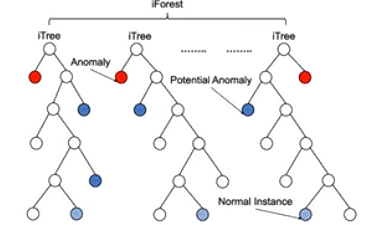

#### Z-Score Method

The Z-Score method detects anomalies by measuring how many standard deviations a data point is from the mean. Data points with absolute Z-Scores above a chosen threshold (e.g., 4) are classified as anomalies (Anomaly detection with Z-score, 2022).

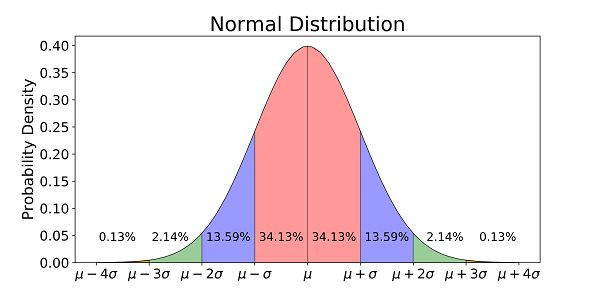

#### One-Class SVM

The One-Class SVM (Support Vector Machine) learns the boundary of normal instances in high-dimensional space and classifies points outside this boundary as anomalies (One-class SVM, 2016).

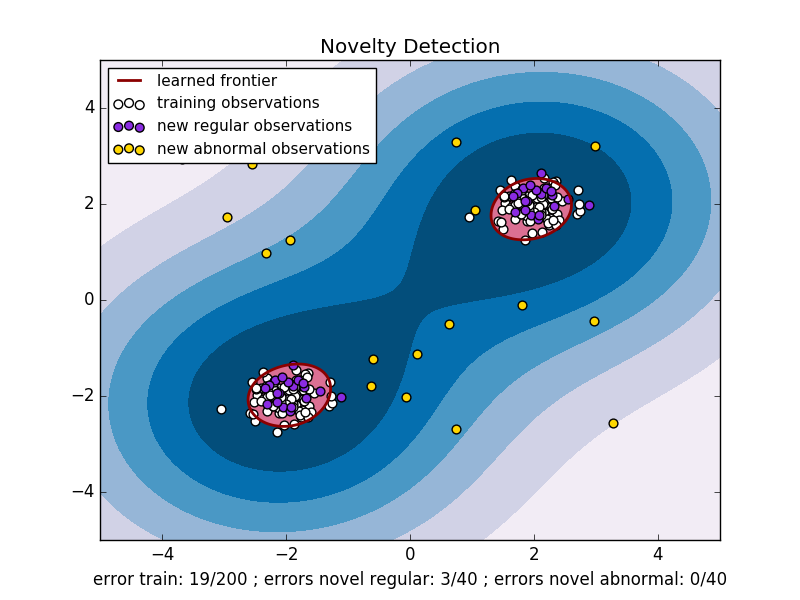

### Why these Methods?

After doing some research (Venujkvenk, 2023), I chose these methods because they seemed like the most applicable methods for my project. These methods also are fairly different so I thought that could create some interesting insights within my data.

## Import Necessary Packages

In [1]:
#Ignores warnings
import warnings
warnings.filterwarnings('ignore')

#Preprocessing packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Plotting packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#Anomaly Detection packages
from sklearn.svm import OneClassSVM
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

## Dataset Preparation

#### Link to dataset

https://nam02.safelinks.protection.outlook.com/?url=https%3A%2F%2Faqicn.org%2Fhistorical%2F%23city%3Adelhi%2Fmundka&data=05%7C02%7CParker.Pratt%40oit.edu%7C62c46dad2b3148fb714608dd5cdb060c%7Cf4db50f235d14e0694e2167755273558%7C0%7C0%7C638768817949481466%7CUnknown%7CTWFpbGZsb3d8eyJFbXB0eU1hcGkiOnRydWUsIlYiOiIwLjAuMDAwMCIsIlAiOiJXaW4zMiIsIkFOIjoiTWFpbCIsIldUIjoyfQ%3D%3D%7C0%7C%7C%7C&sdata=SkuqQLg34xl5eJrxu6VhEtecUHJPnU2ap%2Buu2AQ%2BLcg%3D&reserved=0

In [79]:
#Load dataset
df = pd.read_csv("delhi_air_quality.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2457 entries, 0 to 2456
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       2457 non-null   object
 1    pm25      2457 non-null   object
 2    pm10      2457 non-null   object
 3    o3        2457 non-null   object
 4    no2       2457 non-null   object
 5    so2       2457 non-null   object
 6    co        2457 non-null   object
 7   aqi score  2457 non-null   int64 
 8   quality    2457 non-null   object
dtypes: int64(1), object(8)
memory usage: 172.9+ KB


In [18]:
#Output dirty dataframe
df

,date,pm25,pm10,o3,no2,so2,co,aqi score,quality
0,6/3/2018,,115,17,17,5,8,115,Unhealthy for Sensitive Groups
1,6/4/2018,145,136,17,15,6,8,145,Unhealthy for Sensitive Groups
2,6/5/2018,143,113,13,15,3,8,143,Unhealthy for Sensitive Groups
3,6/6/2018,125,133,8,13,5,9,133,Unhealthy for Sensitive Groups
4,6/7/2018,139,171,8,19,7,11,171,Unhealthy
...,...,...,...,...,...,...,...,...,...
2452,3/3/2025,137,138,34,21,3,4,138,Unhealthy for Sensitive Groups
2453,3/4/2025,168,122,26,16,2,3,168,Unhealthy
2454,3/5/2025,146,122,25,11,2,2,146,Unhealthy for Sensitive Groups
2455,3/6/2025,99,116,33,15,3,2,116,Unhealthy for Sensitive Groups


In [88]:
#Convert empty strings to NaN
df = df.replace(" ", float("NaN"))  

#Make new dataframe
df2 = pd.DataFrame()

#Create new columns
df2["date"] = pd.to_datetime(df["date"])

df["month"] = df2["date"].dt.month
df["season"] = df["month"].apply(lambda x: "Winter" if x in [12, 1, 2] else
                                 "Spring" if x in [3, 4, 5] else
                                 "Summer" if x in [6, 7, 8] else "Fall")

#Convert types
df2["pm25"] = df[" pm25"].astype(float)
df2["pm10"] = df[" pm10"].astype(float)
df2["o3"] = df[" o3"].astype(float)
df2["no2"] = df[" no2"].astype(float)
df2["so2"] = df[" so2"].astype(float)
df2["co"] = df[" co"].astype(float)

#Set "Date" as the index column
df2.set_index('date', inplace=True)

# Sort the DataFrame by the index
df2.sort_index(inplace=True)

#Assign value (It's in the first row so Interpolate won't work without this)
df2["pm25"][0] = df2["pm25"].median()

#Interpolate missing values
df2 = df2.interpolate(method='time')

In [20]:
#Output clean dataframe
df2

,pm25,pm10,o3,no2,so2,co
date,,,,,,
2018-06-03,165.0,115.0,17.0,17.0,5.0,8.0
2018-06-04,145.0,136.0,17.0,15.0,6.0,8.0
2018-06-05,143.0,113.0,13.0,15.0,3.0,8.0
2018-06-06,125.0,133.0,8.0,13.0,5.0,9.0
2018-06-07,139.0,171.0,8.0,19.0,7.0,11.0
...,...,...,...,...,...,...
2025-03-03,137.0,138.0,34.0,21.0,3.0,4.0
2025-03-04,168.0,122.0,26.0,16.0,2.0,3.0
2025-03-05,146.0,122.0,25.0,11.0,2.0,2.0


In [21]:
#Encode categorical variables
label_enc = LabelEncoder()
df2["Season Code"] = label_enc.fit_transform(df["season"])

In [69]:
#Select features to be used
features = ["pm25", "pm10", "o3", "no2", "so2", "co", "Season Code"]
data = df2[features]

## Perform Isolation Forest

In [70]:
#I chose 2.5% so that there are few anomalies to choose from at the very end
model = IsolationForest(contamination=0.025)  #Assume 2.5% of the data are anomalies
model.fit(data)

#Predict anomalies
predictions = model.predict(data)
data["Iso_Anomaly"] = predictions

#Anomalies will be marked as -1
normal = data[predictions == 1]
anomalies = data[predictions == -1]

print("Anomalies detected using Isolation Forest:")
print(anomalies)

Anomalies detected using Isolation Forest:
             pm25   pm10    o3   no2   so2    co  Season Code  Iso_Anomaly
date                                                                      
2018-10-24  212.0  581.0  74.0  39.0  13.0  21.0            0           -1
2018-10-31  349.0  583.0  45.0  36.0  14.0  26.0            0           -1
2018-11-01  375.0  569.0  56.0  42.0  13.0  29.0            0           -1
2018-11-11  403.0  507.0  30.0  37.0  12.0  33.0            0           -1
2018-11-12  403.0  524.0  38.0  38.0  15.0  25.0            0           -1
...           ...    ...   ...   ...   ...   ...          ...          ...
2024-11-14  474.0  423.5   2.0  25.0   4.0  27.0            0           -1
2024-11-18  525.0  877.0  28.0  18.0   7.0  14.0            0           -1
2024-12-17  344.0  635.0  46.0  40.0   5.0  18.0            3           -1
2024-12-19  413.0  572.0  27.0  39.0   4.0  23.0            3           -1
2025-01-04  247.0  609.0  13.0  41.0   4.0  23.0         

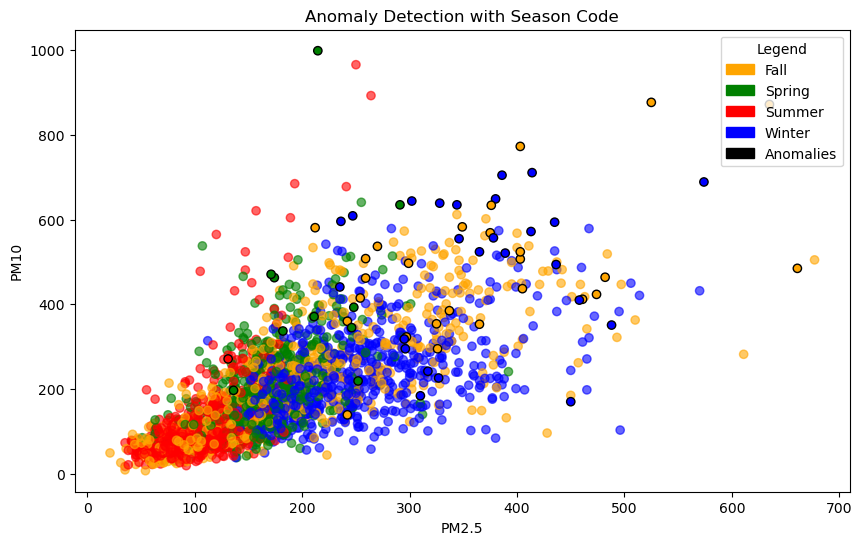

In [71]:
#Define season colors in the correct order (Fall, Spring, Summer, Winter)
season_colors = {0: 'orange', 1: 'green', 2: 'red', 3: 'blue'}

#Assign colors based on 'Season Code'
normal['color'] = normal['Season Code'].map(season_colors)
anomalies['color'] = anomalies['Season Code'].map(season_colors)

#Plot normal vs anomalies colored by season
plt.figure(figsize=(10, 6))
plt.scatter(normal['pm25'], normal['pm10'], color=normal['color'], label='Normal', alpha=0.6)
plt.scatter(anomalies['pm25'], anomalies['pm10'], color=anomalies['color'], edgecolors='black', label='Anomalies', alpha=1)
plt.xlabel('PM2.5')
plt.ylabel('PM10')
plt.title('Anomaly Detection with Season Code')

#legend for seasonal colors
legend_patches = [
    mpatches.Patch(color='orange', label='Fall'),
    mpatches.Patch(color='green', label='Spring'),
    mpatches.Patch(color='red', label='Summer'),
    mpatches.Patch(color='blue', label='Winter'),
    mpatches.Patch(color='black', label='Anomalies')  #Black edges indicate anomalies
]

plt.legend(handles=legend_patches, title="Legend", loc='upper right')
plt.show()

## Perform Z-Score Test

In [72]:
#Find Z-Scores
z_scores = np.abs(zscore(data[["pm25", "pm10", "o3", "no2", "so2", "co"]]))
threshold = 4  #Define threshold for anomaly detection

#Anomaly if z_score is greater than the threshold
data["Z_Anomaly"] = (z_scores > threshold).any(axis=1).astype(int)

## Perform One-Class SVM

In [73]:
#Fit One-Class SVM
svm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.00005)  #Low nu for fewer anomalies
svm.fit(data)

#Predict anomalies
y_pred = svm.predict(data)
data["SVM_Anomaly"] = y_pred

## Visualize the Results

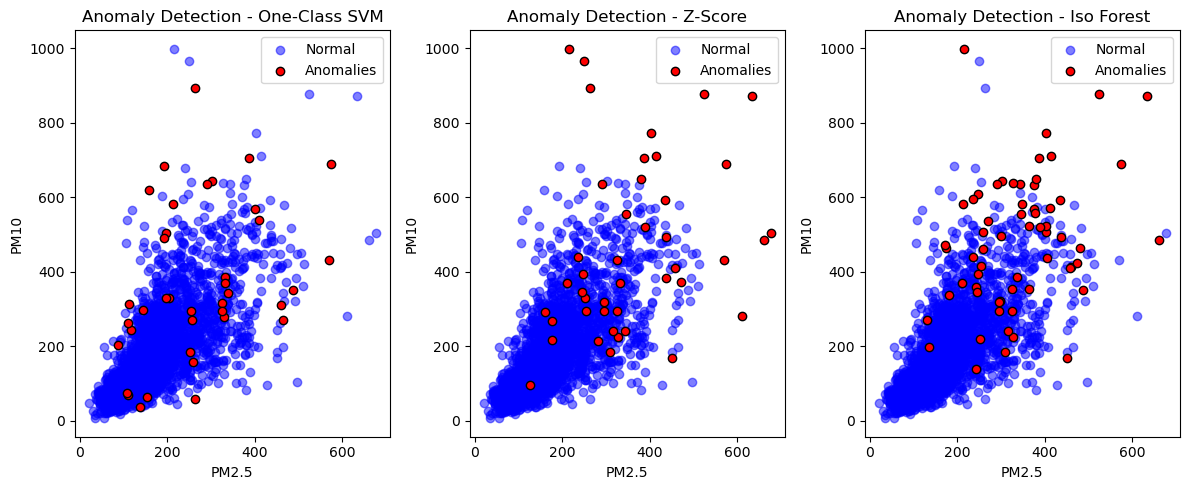

In [77]:
#Plot the three methods next to each other
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

methods = ["SVM_Anomaly", "Z_Anomaly", "Iso_Anomaly"]
titles = ["One-Class SVM", "Z-Score", "Iso Forest"]

for i, method in enumerate(methods):
    normal = data[data[method].isin([0, - 1])]
    anomalies = data[data[method] == 1]

    axes[i].scatter(normal["pm25"], normal["pm10"], color='blue', label="Normal", alpha=0.5)
    axes[i].scatter(anomalies["pm25"], anomalies["pm10"], color='red', edgecolors='black', label="Anomalies", alpha=1)
    axes[i].set_xlabel("PM2.5")
    axes[i].set_ylabel("PM10")
    axes[i].set_title(f"Anomaly Detection - {titles[i]}")
    axes[i].legend()

plt.tight_layout()
plt.show()

## Group Anomalies

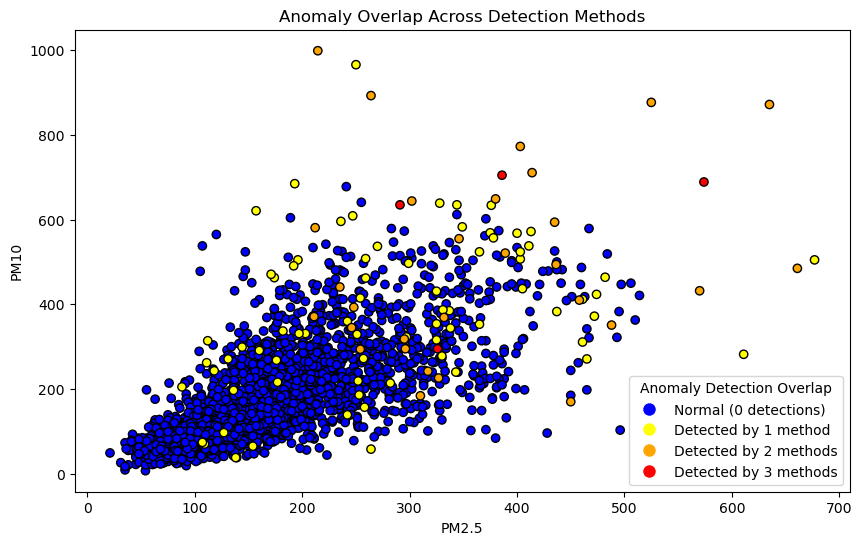

In [75]:
#Standardize anomaly labels (convert everything to 1 = anomaly, 0 = normal)
data["SVM_Anomaly"] = data["SVM_Anomaly"].map({-1: 0, 1: 1})
data["Z_Anomaly"] = data["Z_Anomaly"].map({0: 0, 1: 1})
data["Iso_Anomaly"] = data["Iso_Anomaly"].map({1: 0, -1: 1})

#Sum up anomaly counts (how many methods detected a point as an anomaly)
data["Anomaly_Score"] = data[["SVM_Anomaly", "Z_Anomaly", "Iso_Anomaly"]].sum(axis=1)

#Define colors based on anomaly score (more detections = stronger color)
color_map = {0: "blue", 1: "yellow", 2: "orange", 3: "red"}
data["color"] = data["Anomaly_Score"].map(color_map)

data = data.sort_values(by="Anomaly_Score")

#Plot
plt.figure(figsize=(10, 6))

#Scatter plot with colors based on anomaly score
scatter = plt.scatter(data["pm25"], data["pm10"], c=data["color"], alpha=1, edgecolors="black", zorder=2)

#Add legend
legend_labels = {
    "blue": "Normal (0 detections)",
    "yellow": "Detected by 1 method",
    "orange": "Detected by 2 methods",
    "red": "Detected by 3 methods"
}
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label)
                  for color, label in legend_labels.items()]

plt.legend(handles=legend_patches, title="Anomaly Detection Overlap", loc="lower right")

plt.xlabel("PM2.5")
plt.ylabel("PM10")
plt.title("Anomaly Overlap Across Detection Methods")
plt.show()

In [76]:
#Select points that are anomalies in all three methods
anomalies_all_three = data[data["Anomaly_Score"] == 3]

anomalies_all_three["season"] = anomalies_all_three["Season Code"].apply(lambda x: "Winter" if x in [3] else
                                 "Spring" if x in [1] else
                                 "Summer" if x in [2] else "Fall")

#Drop columns
columns_to_drop = ["Season Code", "Iso_Anomaly", "Z_Anomaly", "SVM_Anomaly", "Anomaly_Score", "color"]
anomalies_all_three = anomalies_all_three.drop(columns=columns_to_drop)

#Display the full dataframe for these points
anomalies_all_three

,pm25,pm10,o3,no2,so2,co,season
date,,,,,,,
2018-11-22,326.0,295.0,19.0,97.0,15.0,16.0,Fall
2024-05-05,291.0,635.0,68.0,42.0,29.0,20.0,Spring
2018-12-27,386.0,705.0,24.0,30.0,13.0,43.0,Winter
2018-12-24,574.0,689.0,21.0,32.0,13.0,32.0,Winter


## Explanation of Results

#### These four rows are the only points that were considered to be anomalies by all three algorithms. Below are some reasons that could have contributed to these points being selected:

* Stubble Burning in Neighboring States: During late October and November, farmers in Punjab, Haryana, and Uttar Pradesh often burn crop residues after the harvest. This practice releases large amounts of smoke and particulate matter into the atmosphere, which can drift to Delhi and significantly degrade air quality (Ellis-Petersen, 2024). 

* Seasonal Weather Conditions: In the winter months, Delhi experiences cooler temperatures and lower wind speeds. These conditions can lead to temperature inversions, where a layer of warm air traps pollutants near the ground, preventing their dispersion and leading to higher concentrations of pollutants like PM2.5 and PM10. In addition, the anomaly in May was partly due to a severe dust storm that passed through (ET Online, 2024).

* Local Emissions: Year-round sources such as vehicular emissions, industrial activities, and construction dust contribute to Delhi's pollution. During the winter, these pollutants can accumulate due to the unfavorable meteorological conditions.

## Conclusion

#### The anomaly detection analyses identified extreme pollution events that could be linked to environmental changes or data anomalies. Each method provided unique insights:

* Isolation Forest effectively detected outliers by using random partitioning.

* Z-Score highlighted values significantly different from the mean.

* One-Class SVM captured complex boundaries of normal pollution patterns.

Combining these methods allows for robust anomaly detection in air quality monitoring. Future work could integrate weather and traffic data for a more comprehensive anomaly detection system.

This project demonstrates how machine learning can uncover hidden patterns in air quality data, aiding in environmental monitoring and policy-making.

# References

Anomaly Detection - Isolation Forest. (2022). Velog.io. https://velog.io/@tjddls321/Anomaly-Detection-Isolation-Forest

Anomaly detection with Z-score - Ascenda Engineering - Ascenda Engineering. (2022). Loyalty.dev. https://loyalty.dev/posts/anomaly-detection-with-z-score

Ellis-Petersen, H. (2024, November 22). “The air is killing us”: why Delhi’s pollution problem runs deeper than smog season. The Guardian; The Guardian. https://www.theguardian.com/world/2024/nov/22/the-air-is-killing-us-why-delhi-india-pollution-problem-runs-deeper-than-smog-season

ET Online. (2024, May 17). Delhi’s pollution worsens: This May is already more polluted than the previous 2 years. The Economic Times; Economic Times. https://economictimes.indiatimes.com/news/india/delhis-pollution-worsens-this-may-is-already-more-polluted-than-the-previous-2-years/articleshow/110202588.cms

One-class SVM with non-linear kernel (RBF) — scikit-learn 0.18.2 documentation. (2016). Scikit-Learn.org. https://scikit-learn.org/0.18/auto_examples/svm/plot_oneclass.html

Venujkvenk. (2023, October 3). Anomaly Detection Techniques: A Comprehensive Guide with Supervised and Unsupervised Learning. Medium. https://medium.com/@venujkvenk/anomaly-detection-techniques-a-comprehensive-guide-with-supervised-and-unsupervised-learning-67671cdc9680